# Import Packages

In [1]:
# General
import sys
import os
from time import time
from collections import OrderedDict 
from importlib import reload
from glob import glob
import itertools
import json
import h5py
import mne
import neo
from tqdm import tqdm
import copy
import pickle
import re

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio
import scipy

# Stats
import scipy.stats as stats
import patsy
from statsmodels.api import OLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests
import random
from sklearn.decomposition import PCA

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import gridspec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D


# Circular
import polars as pl
from pycircstat2 import Circular
from pycircstat2.regression import LCRegression

# Personal 
import getpass
username = getpass.getuser()
print(username)

import sys
sys.path.append(f'/hpc/users/{username}/LFPAnalysis/')
sys.path.append(f'/hpc/users/{username}/LFPAnalysis_SNT/')

from spiketools.utils import set_random_seed
# set_random_seed(101)
random.seed(2024)

import warnings
warnings.filterwarnings('ignore')

jainp08


# Defining functions (by Matt Schafer)

In [2]:
def calculate_angle(U, V=None, direction=None, force_pairwise=False, verbose=False):
    '''
        Calculate angles between n-dim vectors 
        If V == None, calculate U pairwise
        Else, calculate elementwise
        
        TODO: more explanation; find more elegant ways to do this; also adapt other pairwise like functions to have structure

        Arguments
        ---------
        U : array-like
            shape (n_vectors, n_dims)
        V : array-like
            shape (n_vectors, n_dims)
        direction : optional (default=None)
            None : included 180
            False : counterclockwise 360 (wont give a symmetrical matrix)
            True : clockwise 360
            
        Returns
        -------
        numeric 
            pairwise angles in radians

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''
    
    # # testing (10-12-22)
    # U = np.random.randint(100, size=(4,2))
    # for V in [None, np.random.randint(100, size=U.shape), 
    # np.random.randint(100, size=(1, U.shape[1])), np.random.randint(100, size=(7, U.shape[1]))]:

    messages = []

    # check/fix shapes
    if U.ndim == 1: 
        U = np.expand_dims(U, 0)
        messages.append('Added a dimension to U')
        
    if V is not None:
        if V.ndim == 1: 
            V = np.expand_dims(V, 0)
            messages.append('Added a dimension to V')

            
    # determine output shape 
    # - 1 set of vectors: pw, square, symm
    if V is None: 
        default = 'pairwise'
        V = U 
        
    # - 2 vectors of same shape
    # -- pw, square, non-symm
    # -- ew, vector
    elif U.shape == V.shape: 
        default = 'elementwise' 

    # - 2 vectors, 1 w/ length==1 & is reference
    # -- pw, vector shape (1,u)
    elif (U.shape[0] > 1) & (V.shape[0] == 1): 
        V = np.repeat(V, len(U), 0) 
        default = 'reference'  
    
    # -- pw, vector shape (v,1)
    elif (U.shape[0] == 1) & (V.shape[0] > 1): 
        U = np.repeat(U, len(V), 0) 
        default = 'reference' 
        
    # - 2 vectors, different lengths
    # -- pw, rectangle 
    else: 
        default = 'pairwise' 
        
    messages.append(f'Calculated {default}')
    
    
    # calculate angles
    radians = np.zeros((U.shape[0], V.shape[0]))
    for i in range(U.shape[0]):
        for j in range(V.shape[0]):
            radians[i, j] = angle_between_vectors(U[i,:], V[j,:], direction=direction)

            
    # output
    if default == 'pairwise': cols = 'U'
    else:                     cols = 'V'
    radians = pd.DataFrame(radians, index=[f'U{i+1:02d}' for i in range(len(U))], columns=[f'{cols}{i+1:02d}' for i in range(len(V))])

    if not force_pairwise:
        if default == 'reference':
            radians = radians.iloc[:,0].values
        elif default == 'elementwise':
            radians = np.diag(radians)
    if verbose: [print(m) for m in messages]
        
    return radians

def angle_between_vectors(u, v, direction=None, verbose=False):
    '''
        Compute elementwise angle between sets of vectors u & v
            
        uses np.arctan2(y,x) which computes counterclockwise angle [-π, π] between origin (0,0) and x, y
        clockwise v. counterclockwise: https://itecnote.com/tecnote/python-calculate-angle-clockwise-between-two-points/  
        included: ADD LINK

        TODO: make pairwise..?

        Arguments
        ---------
        u : array-like
            vector
        v : array-like
            another vector
        direction : None, True or False (optional, default=None)
            None == Included
            True == Clockwise 360
            False == Counterclockwise 360 
        verbose : bool (optional, default=False)
             
        Returns
        -------
        float 
            angle in radians 

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''

    #     if U.shape != V.shape:
    #         if verbose: print(f'Different shape vectors: U={U.shape}, V={V.shape}. Assuming smaller is reference.')
    #         if len(U) < len(V): U = np.repeat(np.expand_dims(U, 0), len(V), axis=0)
    #         else:               V = np.repeat(np.expand_dims(V, 0), len(U), axis=0)
    #     rads = []
    #     for u, v in zip(U, V):            
    # if one of vectors is at origin, the angle is undefined but could be considered as orthogonal (90 degrees)
    if ((u==0).all()) or ((v==0).all()): 
        if verbose: print(u, v, 'at least 1 vector at origin; treating as orthogonal')
        rad = np.pi/2

    # if same vectors (or scalar multiples of each other) being compared, no angle between (0 degrees)
    # -- b/c 0-360 degrees, direction matters: make sure the signs are the same too
    elif (_coincident_vectors(u, v)) & all(np.sign(u) == np.sign(v)):
        if verbose: print(u, v, 'same vectors, no angle in between')
        rad = 0 # 0 degrees == 360 degrees == 2*pi radians 

    else:

        if direction is None: 

            # "included" angle from [0,180], [0, π] 
            rad = np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))
            # equivalent: np.arctan2(l2_norm(np.cross(u, v)), np.dot(u, v))

        elif direction is True: 

            # clockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*v[::-1]) - np.arctan2(*u[::-1])) % (2 * np.pi)  
        
        elif direction is False:

            # counterclockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*u[::-1]) - np.arctan2(*v[::-1])) % (2 * np.pi)
            
    return rad

def _coincident_vectors(u, v):
    ''' Checks if vectors (u & v) are the same or scalar multiples of each other'''
    return np.dot(u, v) * np.dot(u, v) == np.dot(u, u) * np.dot(v, v)


def get(x, y):
    return 6*(int(x)-y)/y

# Setting parameters

In [3]:
subj_id = 'MS045'
subj_format = ['edf']
subj_site = ['MSSM']
subj_task = 'SNT'
# task_sess = 'session_0'

if username == 'tostag01':
    base_dir = '/sc/arion/projects/OlfMem/tostag01/SocialNav'
    data_dir = f'/sc/arion/projects/OlfMem/jainp08/Social_Navigation/data/{subj_id}/'

if username == 'jainp08':
    base_dir = '/sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/'
    data_dir = f'/sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/{subj_id}/'

anat_dir = f'{data_dir}anat/'
neural_dir = f'{data_dir}raw/neural/'
behav_dir = f'{data_dir}raw/behav/'

preproc_dir = f'{base_dir}../preproc/{subj_id}/'
scripts_dir = f'{base_dir}scripts/'
behav_preproc = f'{preproc_dir}behav/'
plots_dir = f'{base_dir}../plots/{subj_id}/'

# synapse_dir = '/Volumes/synapse/projects/Social_Navigation/single_unit/SH-SNT/'
# spikes_dir = f'{synapse_dir}recordings/{subj_id}/{subj_task}/{task_sess}/03_extracted/spikes/'

In [6]:
# behavior_file = {}
# behavior_file = glob(f'{behav_dir}/*.xlsx')[0]

# df_behavior = pd.read_excel(behavior_file)
# df_behavior

choice_file = glob(f'{behav_dir}/*_data.xlsx')[0]
behav_df_dots = pd.read_excel(choice_file)
behav_df = pd.read_excel(choice_file)
# behav_df = behav_df[behav_df['dimension'] != 'neutral']


# Populating choice_df

In [7]:
decision_info_all = pd.read_csv(f'{base_dir}/Decision_info.csv')
decision_info = decision_info_all[decision_info_all['Dimension'] != 'neutral']
# #choice_df = pd.concat([choice_df,decision_info], axis=1, join="inner")

main_character_list = ['First', 'Second', 'Powerful', 'Boss', 'Assistant']
role_dict = {'Maya': '',
                'Chris': '',
                'Newcomb': 'Powerful',
                'Hayworth': 'Boss',
                'Anthony': '',
                'Kayce': ''}

color_list = {'First': 'tab:blue',
              'Second': 'tab:orange',
              'Powerful': 'tab:green',
              'Boss': 'tab:red',
              'Assistant': 'tab:purple',
              'Neutral': 'tab:brown'}

main_character_list = ['First', 'Second', 'Powerful', 'Boss', 'Assistant']
all_character_list = main_character_list + ['Neutral']
social_dimension_list = ['affiliation', 'power']
all_dimension_list = social_dimension_list + ['neutral']

trials = {}
for dimension in all_dimension_list:
    trials[dimension] = (
        decision_info_all.Dimension==dimension).astype(bool).values

for character in all_character_list:
    trials[character] = (
        decision_info_all.Character==character).astype(bool).values


In [8]:
choice_df = behav_df
choice_df['char'] = decision_info_all['Character'].tolist()
choice_df['decision_axis'] = decision_info_all['Dimension'].tolist()

# Initialize columns
choice_df['x'] = 0
choice_df['y'] = 0
choice_df['r_current'] = 0
choice_df['r_new'] = 0
choice_df['angle_current'] = 0
choice_df['angle_new'] = 0
choice_df['decision_id'] = [0 if x == 'affil' else 1 for x in choice_df['dimension']]

# Dictionary to track the cumulative affil and power for each character
xy = {f'{char_role_num}': {'affil': 0, 'power': 0} for char_role_num in [1, 2, 3, 4, 5, 9]}

for index, row in choice_df.iterrows():
    char_role_num = str(row['char_role_num'])
    
    # Current (previous) position of the character
    x = xy[char_role_num]['affil']
    y = xy[char_role_num]['power']
    
    # Update position based on the current trial
    new_x = x + row['affil']
    new_y = y + row['power']
    
    # Update the cumulative position for the character
    xy[char_role_num]['affil'] = new_x
    xy[char_role_num]['power'] = new_y
    
    # Save new positions to choice_df
    choice_df.at[index, 'x'] = new_x
    choice_df.at[index, 'y'] = new_y
    
    # Calculate current and new vector lengths (r_current and r_new)
    choice_df.at[index, 'r_current'] = np.sqrt((6 - x)**2 + y**2)
    choice_df.at[index, 'r_new'] = np.sqrt((6 - new_x)**2 + new_y**2)

    # Use calculate_angle to find the angle between POV and the character’s position
    pov = np.array([6, 0])  # Point-of-view at (6, 0)
    
    # Current vector relative to POV
    current_vector = np.array([[x, y]]) - pov  # From POV to character's current position
    
    # New vector relative to POV
    new_vector = np.array([[new_x, new_y]]) - pov  # From POV to character's new position
    
    # Corrected reference vector: from POV to (6, 6) (max affil and power)
    reference_vector = np.array([[6, 6]]) - pov  # This is the correct vector for reference
    
    # Calculate angles using the calculate_angle function
    current_angle = calculate_angle(current_vector, reference_vector, direction=None)
    new_angle = calculate_angle(new_vector, reference_vector, direction=None)
    # print('angle current from calc', current_angle)
    # print('angle new from calc', new_angle)
    
    # Update choice_df with the calculated angles
    choice_df.at[index, 'raw_angle'] = current_angle[0]  # Angle for current position
    choice_df.at[index, 'raw_angle_new'] = new_angle[0]  # Angle for new position
        
    current_vector = current_vector.ravel() 
    new_vector = new_vector.ravel()  
    reference_vector = reference_vector.ravel() 
    
    # Calculate cosine similarity for current position
    dot_product_current = np.dot(current_vector, reference_vector)  # Now vectors are 1D
    norm_current = np.linalg.norm(current_vector)
    norm_reference = np.linalg.norm(reference_vector)
    cosine_current = dot_product_current / (norm_current * norm_reference)
    
    # Calculate cosine similarity for new position
    dot_product_new = np.dot(new_vector, reference_vector)  # Now vectors are 1D
    norm_new = np.linalg.norm(new_vector)
    cosine_new = dot_product_new / (norm_new * norm_reference)
    
    # Update choice_df with cosine of the angles
    choice_df.at[index, 'cosine_current'] = cosine_current  # Cosine similarity for current position
    choice_df.at[index, 'cosine_new'] = cosine_new  # Cosine similarity for new position

In [9]:
preproc_dir
if not os.path.exists(preproc_dir):
    os.makedirs(preproc_dir)
choice_df.to_csv(f'{preproc_dir}/behav/choice_df_all.csv', index=False)

In [8]:
os.listdir(preproc_dir)

['LFP', 'behav']

In [11]:
choice_df

,decision_num,char_decision_num,scene_num,dimension,char_role_num,onset,button_press,decision,affil,power,reaction_time,char,decision_axis,x,y,r_current,r_new,angle_current,angle_new,decision_id,raw_angle,raw_angle_new,cosine_current,cosine_new
0,1,1,1,affil,1,96.040977,1,1,1,0,6.944526,First,affiliation,1,0,6.000000,5.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
1,2,2,1,affil,1,111.522888,1,-1,-1,0,7.726468,First,affiliation,0,0,5.000000,6.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
2,3,3,1,affil,1,129.313385,2,-1,-1,0,9.089585,First,affiliation,-1,0,6.000000,7.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
3,4,4,2,power,1,156.195755,1,1,0,1,7.177432,First,power,-1,1,7.000000,7.071068,0,0,1,1.570796,1.428899,0.000000,0.141421
4,5,1,2,affil,2,183.250793,2,-1,-1,0,6.694229,Second,affiliation,-1,0,6.000000,7.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
5,6,2,2,power,2,211.789948,2,-1,0,-1,5.891699,Second,power,-1,-1,7.000000,7.071068,0,0,1,1.570796,1.712693,0.000000,-0.141421
6,7,5,3,power,1,233.955124,1,-1,0,-1,10.006123,First,power,-1,0,7.071068,7.000000,0,0,1,1.428899,1.570796,0.141421,0.000000
7,8,6,3,affil,1,246.024033,1,1,1,0,3.654070,First,affiliation,0,0,7.000000,6.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
8,9,7,3,affil,1,274.165100,2,1,1,0,7.396753,First,affiliation,1,0,6.000000,5.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
9,10,3,4,power,2,301.256378,1,-1,0,-1,6.357466,Second,power,-1,-2,7.071068,7.280110,0,0,1,1.712693,1.849096,-0.141421,-0.274721


In [10]:
f'{preproc_dir}/choice_df_all.csv'

'/sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/../preproc/MS045//choice_df_all.csv'

In [10]:
choice_df.to_csv(f'{preproc_dir}/choice_df_all.csv', index=False)

# Plotting dots

## Final locations

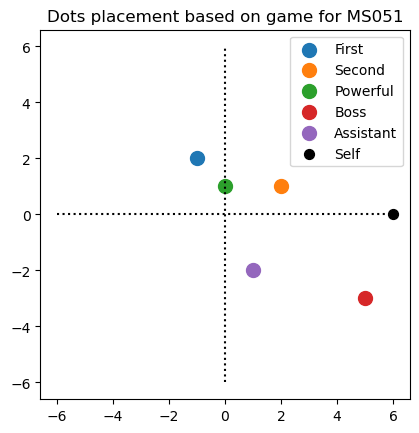

In [11]:
for character in main_character_list:
    affil_x = behav_df_dots[trials[character] & trials['affiliation']]['affil'].sum()
    power_y = behav_df_dots[trials[character] & trials['power']]['power'].sum()
    plt.scatter(affil_x, power_y, c=color_list[character], s=100)
    
plt.scatter(6, 0, c='k', s=50)
character_list = main_character_list.copy() + ['Self']
plt.legend(character_list)
plt.plot([-6, 6], [0, 0], 'k:')
plt.plot([0, 0], [-6, 6], 'k:')
plt.title('Dots placement based on game for ' + subj_id)
plt.axis('square')
plt.show()

## Character trajectories

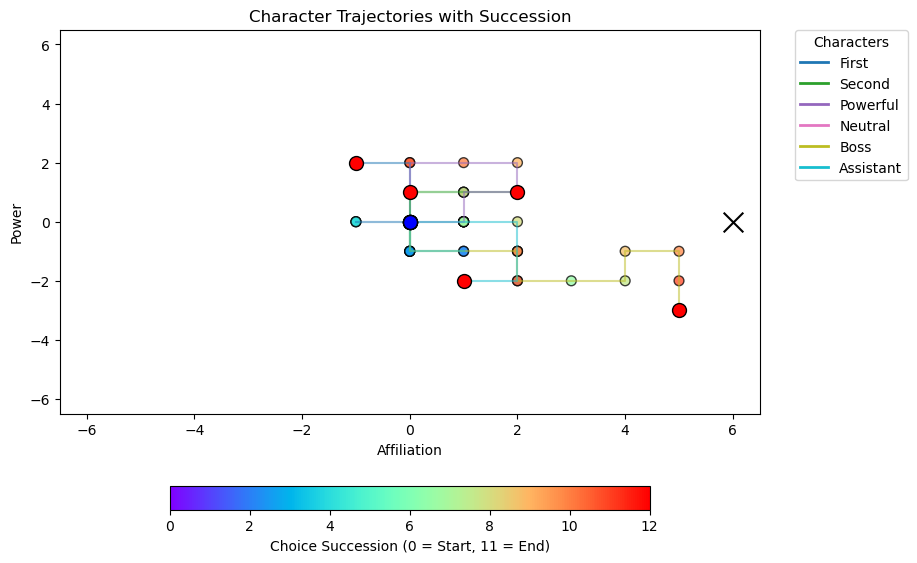

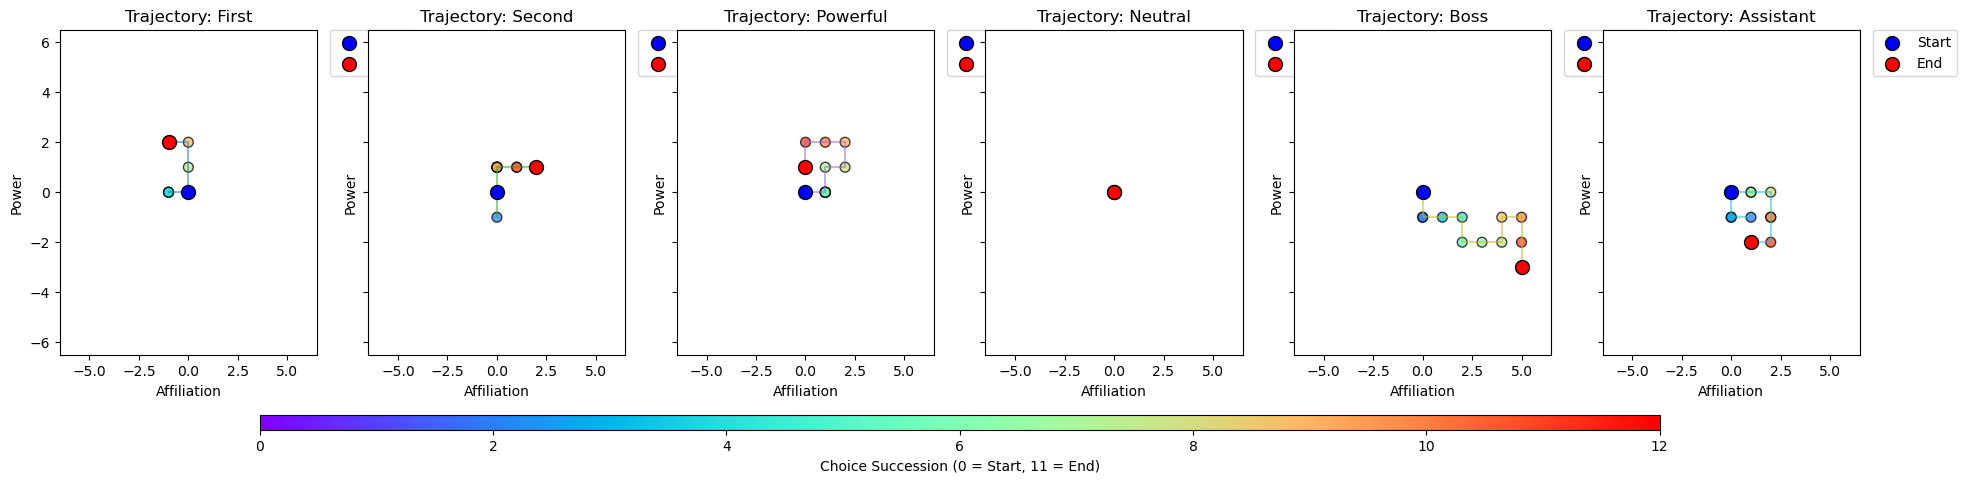

In [12]:
# Get unique characters
characters = choice_df['char'].unique()

# Create a color map for each character
cmap = cm.get_cmap('tab10', len(characters))
clrmap = 'rainbow'

# Create a figure for the combined plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each character
for i, char in enumerate(characters):
    df_char = choice_df[choice_df['char'] == char]
    
    # Ensure trajectories start at (0, 0)
    if not (df_char['x'].iloc[0] == 0 and df_char['y'].iloc[0] == 0):
        df_char = pd.concat([pd.DataFrame({'x': [0], 'y': [0], 'char': [char]}), df_char], ignore_index=True)
    
    x_coords = df_char['x']
    y_coords = df_char['y']
    
    # Get number of points
    num_points = len(x_coords)
    
    # Color gradient based on succession
    colors_gradient = cm.get_cmap(clrmap)(np.linspace(0, 1, num_points))
    
    # Plot points and trajectory
    sc = ax.scatter(x_coords, y_coords, c=np.arange(num_points), cmap=clrmap, s=50, edgecolor='k', alpha=0.75, label=f'{char}')
    ax.plot(x_coords, y_coords, color=cmap(i), alpha=0.5)
    
    # Mark start and end points
    ax.scatter(x_coords.iloc[0], y_coords.iloc[0], color='blue', s=100, edgecolor='black', zorder=5, label='Start' if i == 0 else "")
    ax.scatter(x_coords.iloc[-1], y_coords.iloc[-1], color='red', s=100, edgecolor='black', zorder=5, label='End' if i == 0 else "")

# Mark point (6, 0)
ax.scatter(6, 0, color='black', marker='x', s=200, label='(6, 0)', zorder=10)

# Set axis limits
ax.set_xlim(-6.5, 6.5)
ax.set_ylim(-6.5, 6.5)

# Custom legend
legend_elements = [Line2D([0], [0], color=cmap(i), lw=2, label=char) for i, char in enumerate(characters)]
ax.legend(handles=legend_elements, title="Characters", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Labels and title
ax.set_xlabel('Affiliation')
ax.set_ylabel('Power')
ax.set_title('Character Trajectories with Succession')

# Color bar to show decision succession
norm = Normalize(vmin=0, vmax=num_points-1)
sm = ScalarMappable(cmap=clrmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)  # Increase padding for clarity
cbar.set_label('Choice Succession (0 = Start, 11 = End)')

# Show combined plot
plt.subplots_adjust(left=0.05, right=0.75, top=0.9, bottom=0.1)  # Manually adjust subplot margins for more space
plt.show()
# plt.savefig(plots_dir + subj_id + ' task trajectories all.png')

# Individual subplot layout with spacing
fig, axes = plt.subplots(1, len(characters), figsize=(20, 5), sharex=True, sharey=True)

# Plot for each character
for i, char in enumerate(characters):
    ax = axes[i]
    
    df_char = choice_df[choice_df['char'] == char]
    
    # Ensure trajectories start at (0, 0)
    if not (df_char['x'].iloc[0] == 0 and df_char['y'].iloc[0] == 0):
        df_char = pd.concat([pd.DataFrame({'x': [0], 'y': [0], 'char': [char]}), df_char], ignore_index=True)
    
    x_coords = df_char['x']
    y_coords = df_char['y']
    
    # Get number of points
    num_points = len(x_coords)
    
    # Color gradient for choices
    colors_gradient = cm.get_cmap(clrmap)(np.linspace(0, 1, num_points))
    
    # Plot points and trajectory
    sc = ax.scatter(x_coords, y_coords, c=np.arange(num_points), cmap=clrmap, s=50, edgecolor='k', alpha=0.75)
    ax.plot(x_coords, y_coords, color=cmap(i), alpha=0.5)
    
    # Mark start and end points
    ax.scatter(x_coords.iloc[0], y_coords.iloc[0], color='blue', s=100, edgecolor='black', zorder=5, label='Start')
    ax.scatter(x_coords.iloc[-1], y_coords.iloc[-1], color='red', s=100, edgecolor='black', zorder=5, label='End')

    # Set title and labels
    ax.set_title(f'Trajectory: {char}')
    ax.set_xlabel('Affiliation')
    ax.set_ylabel('Power')
    
    # Set axis limits
    ax.set_xlim(-6.5, 6.5)
    ax.set_ylim(-6.5, 6.5)

    # Adjust legend to avoid overlapping plot data
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Color bar for the subplots
norm = Normalize(vmin=0, vmax=num_points-1)
sm = ScalarMappable(cmap=clrmap, norm=norm)
sm.set_array([])  # Only needed to create a color bar
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Choice Succession (0 = Start, 11 = End)')

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.2)  # Custom adjustments to provide space for colorbars and legends

# Show the individual plots
plt.show()
# plt.savefig(plots_dir + subj_id + ' task trajectories per character.png')